### Common Analysis
More and more frequently summers in the western US have been characterized by wildfires with smoke billowing across multiple western states. There are many proposed causes for this: climate change, US Forestry policy, growing awareness, just to name a few. Regardless of the cause, the impact of wildland fires is widespread. There is a growing body of work pointing to the negative impacts of smoke on health, tourism, property, and other aspects of society.
The course project will require that you analyze wildfire impacts on a specific city in the US. The end goal is to be able to inform policy makers, city managers, city councils, or other civic institutions, to make an informed plan for how they could or whether they should make plans to mitigate future impacts from wildfires.

Downloading the correct combined data set and now taking from google the longtitude and latitude estimaes from the cite https://www.latlong.net/place/coeur-d-alene-id-usa-32252.html cited in the read me to find the distance parameters for the coordinate 

Also PiP installing the geopy, pyproj, wilde file reader in the system so it can read the code properly 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import seaborn as sns
from pyproj import Transformer, Geod

# The module pyproj is a standard module that can be installed using pip or your other favorite
#  installation tool. This module provides tools to convert between different geodesic coordinate systems
#  and for calculating distances between points (coordinates) in a specific geodesic system.

from Reader import Reader
# pulled file wildfire.reader for space capcity : described ads
#The a GeoJSON reader that you might try if you wanted to read the data. 

from geopy.distance import geodesic
# the geopy reader connecting to wildefire ciruct from pyproj and wildfire site

fname_c = "/Users/nhoward/Documents/Fall23_Senior/Data512/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json"
coeur_d_alene_long_lat = (47.702465, - 116.796883)
# long, lat, corrdinates from my city in Idaho coeur_d_alene



## Step 0: Data acquisition
The common analysis research question is based on one specific dataset. You should get the Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons) dataset. This dataset was collected and aggregated by the US Geological Survey. The dataset is relatively well documented. Fire polygons are available in ArcGIS and GeoJSON formats.
You have been assigned a specific US city as the focus of your analysis. You are NOT analyzing the entire dataset. You have been assigned one US city that will form the basis for your individual analysis. You can find your individual US city assignment from this Google spreadsheet.

Snipped of code is taken from the constructor and talked about using snippets within 
this document to manually take the correct features for the smoke estimate in the data frame 

Disscused a snipped with class mates on limiting the runtime capacity through 
selected only one feature from the attribute then dumping as a json like article pull request 
becasue there more efficent 
[
attributes = feature['attributes'] 
    print(json.dumps(feature, indent=4))
]

In [3]:
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 

# instructor set up 
wf_reader = Reader(fname_c) # running from instuctors object python file that reads from the wildfire 
feature = wf_reader.next()

while feature_count < 5: #Instructor set up 
    feature_count += 1
    
    attributes = feature['attributes'] #each feature has an attribute the links to parts we need such long, lat
    print(json.dumps(feature, indent=4))
    feature = wf_reader.next() # get linked list objects of latitudes from cite list by instructers class object

{
    "attributes": {
        "OBJECTID": 1,
        "USGS_Assigned_ID": 1,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1860,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1)",
        "GIS_Acres": 3940.20708940724,
        "GIS_Hectares": 1594.5452365353703,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)",
        "Listed_Fire_Types": "Wildfire (1)",
        "Listed_Fire_Names": "Big Quilcene River (1)",
        "Listed_Fire_Codes": "No code provided (1)",
        "Listed_Fire_IDs": "",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)",
        "Listed_Fire_Causes": "",
        "Listed_Fire_Cause_Class": "Undetermined (1)",
        "Listed_Rx_Reported_Acres": null,
        "Listed_Map_Digitize_Methods": "Other (1)",
        "Listed_Notes": "",
        "Processing_Notes": "",
        "Wildfire_Notice": "Wildfire mapping prior 

Instructors code to get the geometry data and pull a geometry of our wildfire data are generic polygons and that they are expressed in a coordinate system with the well-known ID (WKID) 102008. This coordinate system is also known as ESRI:102008

In [4]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326

def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

The instructor explains this function better as it's complicated as a caculation that is the average distance of all perimeter points to the city (place) and returns that average as the distance. This is not quite what the centroid would be, but it is probably fairly close.
split into the perimeter of a fire and the distance .
caculated between the shorts route and average amount from the total 

In [5]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the poi

def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

In [134]:
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place

def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

I struggle calculting the average distance from the total path:
from the read me I took the feature collection from the instructor explains this function better as it's complicated as a caculation that is the average distance of all perimeter points to the city (place) and returns that average as the distance. This is not quite what the centroid would be, but it is probably fairly close.
split into the perimeter of a fire and the distance .
caculated between the shorts route and average amount from the total 

But I disscussed this with four other class mates getting the  featues
of the distance and and average then go the snipped collbrated togther to be :
[
if distance_s[0] <= 1250.00:
    wf_feature['attributes']['Shortest_distance'] = distance_s[0]
    wf_feature['attributes']['Average_distance']  = distance_a
]

Where each objec is filtereing the step one proccess
and saving my own resutls in json for speed effeciency

In [11]:
# created as a count from each json object dumped to linked list speed time 
filtered_fires = []
iteration_count = 0

feature_count = 0 
wf_reader = Reader(fname_c)
wf_feature = wf_reader.next() 
# instructor set up  
# running from instuctors object python file that reads from the wildfire 
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result


#
#     Compute using the shortest distance to any point on the perimeter
#
while wf_feature:
     
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]

        if type(wf_year) == int and wf_year >= 1963:  # Compute using the shortest distance to any point on the perimeter
            distance_s= shortest_distance_from_place_to_fire_perimeter(coeur_d_alene_long_lat, ring_data)
            distance_a = average_distance_from_place_to_fire_perimeter(coeur_d_alene_long_lat, ring_data)

            if distance_s[0] <= 1250.00:
                wf_feature['attributes']['Shortest_distance'] = distance_s[0]
                wf_feature['attributes']['Average_distance']  = distance_a
                filtered_fires.append(wf_feature['attributes'])

            if (feature_count % 50000) == 0:
                print(f"The closest distance of fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was {distance_s[0]:1.2f} miles to Coeur d'Alene")
                
                filitered_fires_file = f"Idaho_Coeur_d'Alene_Fires{iteration_count}.json"
                with open(filitered_fires_file, "w") as f3:
                    json.dump(filtered_fires, f3)
                
                filtered_fires = []
                iteration_count += 1
        
    feature_count += 1
    wf_feature = wf_reader.next()
    
print(len(filtered_fires))

if filtered_fires:
    filitered_fires_file = f"Idaho_Coeur_d'Alene_Fires{iteration_count}.json"
    with open(filitered_fires_file, "w") as f3:
        json.dump(filtered_fires, f3)
        
#
#Compute using the average distance to all points on the perimeter
#
#distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
#print(f"Fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was an average {distance:1.2f} miles to {place['city']}")
#ring = convert_ring_to_epsg4326(ring_data)
#perimeter_start = ring[0]
#print(f"\tOne perimiter point lat,lon {perimiter_start[0]},{perimeter_start[1]}")


The closest distance of fire 'Abandon (3)' (0.71 acres) from 2005 was 740.37 miles to Coeur d'Alene
The closest distance of fire 'UNNAMED (1)' (716.68 acres) from 2003 was 1493.21 miles to Coeur d'Alene
20626


Saved as a df to limit the amount place into the chuncks as suggested in the api 
and then conjoined in chuncks toge the data frame where
it's concluded to have a description of 77,978 rows and 32 columns in size 

In [12]:
wild_fire_df = []

for i in range(iteration_count+1):
    wild_fire_df.append(pd.read_json(f"Idaho_Coeur_d'Alene_Fires{i}.json"))
    
wild_fire_df = pd.concat(wild_fire_df, ignore_index=True)
wild_fire_df.shape

(77978, 32)

In [13]:
iteration_count.describe()

,OBJECTID,USGS_Assigned_ID,Fire_Year,Fire_Polygon_Tier,GIS_Acres,GIS_Hectares,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,Shortest_distance,Average_distance
count,77978.000000,77978.000000,77978.000000,77978.000000,7.797800e+04,77978.000000,77978.000000,6205.0,7.797800e+04,7.797800e+04,77978.000000,77978.000000
mean,71004.920529,71004.920529,2001.302034,2.916887,1.905267e+03,771.034174,0.475199,1.0,1.057064e+04,7.710342e+06,597.244045,597.783736
std,36464.204561,36464.204561,14.687507,2.731474,1.390870e+04,5628.650664,0.259704,0.0,3.747536e+04,5.628651e+07,290.906409,290.940923
min,14299.000000,14299.000000,1963.000000,1.000000,4.697010e-06,0.000002,0.000051,1.0,6.295036e-01,1.900813e-02,3.086842,3.268284
25%,39727.500000,39727.500000,1990.000000,1.000000,1.630818e+01,6.599688,0.269295,1.0,1.296470e+03,6.599688e+04,373.982442,374.676456
50%,66109.500000,66109.500000,2005.000000,1.000000,8.301199e+01,33.593760,0.441256,1.0,3.334179e+03,3.359376e+05,570.074347,570.490578
75%,105481.750000,105481.750000,2014.000000,6.000000,5.438506e+02,220.088545,0.647943,1.0,9.315877e+03,2.200885e+06,805.699700,806.187130
max,135061.000000,135061.000000,2020.000000,8.000000,1.032651e+06,417899.203637,0.997980,1.0,3.769124e+06,4.178992e+09,1249.975244,1256.648659


In [ ]:
iteration_count.to_csv("Idaho_Coeur_d'Alene_Fires.csv")  #saving into a data set for efficiency stage 

Step 1: Create fire smoke estimates
The common research question that you are to answer is:
What are the estimated smoke impacts on your assigned city for the last 60 years?
You are to create an annual estimate of wildfire smoke in your assigned city. This estimate is just a number that you can eventually use to build a predictive model. Technically, smoke impact should probably be considered the health, tourism, economic or other social problems that result from the smoke. For this we'll generically call your estimate the wildfire smoke impact. You will consider other potential social and economic impacts during Part 2 of the course project. For now, you need some kind of number to represent an estimate of the smoke your city saw during each annual fire season.

Conditions:
- The estimate only considers the last 60 years of wildland fires (1963-2023).
- The estimate only considers fires that are within 1250 miles of your assigned city.
- An annual fire season will run from May 1st through October 31st.


## Data Cleanning Stage

#### The data cleaning stage has check list to how I will find my best smoke estimate given the data constrais in the 
#### common analysis part 1 , Those are:
    - checking the data types corretcly 
    - ensurng the correct range 
    - eliminate primary key duplicates 
    - ensuring uniformaity of the data 
    - checking the nulls and outliers of the data 
    


In [14]:
coeur_fires_df = pd.read_csv("Idaho_Coeur_d'Alene_Fires.csv")# reading the data frame into the set 
len(filtered_fires) #20817 # checking all rows are inside the data from chuncking the sets 

In [17]:
coeur_fires_df = pd.read_csv("Idaho_Coeur_d'Alene_Fires.csv")

/var/folders/zl/sc371gd517n0657kksp61jth0000gn/T/ipykernel_2301/2215569752.py:1: DtypeWarning: Columns (0,1,2,5,8,14,21) have mixed types. Specify dtype option on import or set low_memory=False.
  coeur_fires_df = pd.read_csv("Idaho_Coeur_d'Alene_Fires.csv")


 The messaging prompt shows theres mixed data types in 
columns (0,1,2,5,8,14,21)
#checking the object dtypes for the columns to object assigned 

In [18]:
coeur_fires_df.head()

,Unnamed: 0,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,...,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,Shortest_distance,Average_distance
0,0,14299,14299,Wildfire,1963.0,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,Prescribed fire data in this dataset represent...,NaN,NaN,0.385355,NaN,No,73550.428118,1.658906e+08,232.896793,236.375298
1,1,14300,14300,Wildfire,1963.0,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,Prescribed fire data in this dataset represent...,NaN,NaN,0.364815,NaN,No,59920.576713,1.042352e+08,218.626866,222.464026
2,2,14301,14301,Wildfire,1963.0,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,Prescribed fire data in this dataset represent...,NaN,NaN,0.320927,NaN,No,84936.827810,1.842421e+08,223.460659,229.342460
3,3,14302,14302,Wildfire,1963.0,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,Prescribed fire data in this dataset represent...,NaN,NaN,0.428936,NaN,No,35105.903602,4.206711e+07,310.426039,313.592449
4,4,14303,14303,Wildfire,1963.0,1,"1 (1), 3 (3)",9983.605738,4040.2219,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,Prescribed fire data in this dataset represent...,NaN,NaN,0.703178,NaN,No,26870.456126,4.040222e+07,245.900959,247.732655


In [8]:
coeur_fires_df.columns

Index(['Unnamed: 0', 'OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type',
       'Fire_Year', 'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area'],
      dtype='object')

checking the dtypes and I see mostly the correct objects except that year should be a time stamp or object or into not a float depending on the analysis Im checking  and the describe function to check the range of min ad max for the years to make sure the data is ranged properly 

In [85]:
coeur_fires_df.dtypes

Unnamed: 0                       object
OBJECTID                         object
USGS_Assigned_ID                 object
Assigned_Fire_Type               object
Fire_Year                       float64
Fire_Polygon_Tier                object
Fire_Attribute_Tiers             object
GIS_Acres                       float64
GIS_Hectares                     object
Source_Datasets                  object
Listed_Fire_Types                object
Listed_Fire_Names                object
Listed_Fire_Codes                object
Listed_Fire_IDs                  object
Listed_Fire_IRWIN_IDs            object
Listed_Fire_Dates                object
Listed_Fire_Causes               object
Listed_Fire_Cause_Class          object
Listed_Rx_Reported_Acres         object
Listed_Map_Digitize_Methods      object
Listed_Notes                     object
Processing_Notes                 object
Wildfire_Notice                  object
Prescribed_Burn_Notice           object
Wildfire_and_Rx_Flag             object


In [20]:
coeur_fires_df.describe()# checks the uniformity range of years to be the time range of intreset 

,Fire_Year,GIS_Acres,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,Shortest_distance,Average_distance
count,85313.000000,8.531300e+04,77977.000000,6205.0,7.797700e+04,7.797700e+04,77977.000000,77977.000000
mean,2002.479751,2.206054e+03,0.475203,1.0,1.057020e+04,7.710160e+06,597.235732,597.775403
std,14.557501,1.333345e+04,0.259703,0.0,3.747539e+04,5.628684e+07,290.899013,290.933484
min,1963.000000,4.697010e-06,0.000051,1.0,6.295036e-01,1.900813e-02,3.086842,3.268284
25%,1992.000000,1.960203e+01,0.269300,1.0,1.296415e+03,6.599279e+04,373.981652,374.675505
50%,2007.000000,1.138734e+02,0.441262,1.0,3.334062e+03,3.359184e+05,570.065521,570.486629
75%,2015.000000,1.095614e+03,0.647944,1.0,9.315555e+03,2.200673e+06,805.654909,806.169144
max,2020.000000,1.032651e+06,0.997980,1.0,3.769124e+06,4.178992e+09,1249.975244,1256.648659


Turns the data ranges from 1963 to 2020 so I have to make sure the api is cutting into the same averages so that its an estimate on the same conformity and not scalled to incorrectly  if just an aqi count.

- next i check the uniqueness of the primary id it seems the shape of the data does not duplicate and cheack row is unique
- Finally checking what rows of instreset have alot of missing data percentage, I wont caculate 

In [24]:
len(coeur_fires_df['OBJECTID'].unique()) # check and saw including the data collected had 77,978 so the one extra row was column names

77979

In [26]:
coeur_fires_df_missing = coeur_fires_df.isna() # gets null from the data filtered
coeur_fires_df_missing = coeur_fires_df_missing.sum() # counts them 
coeur_fires_df_missing/ len(coeur_fires_df) # divides for the percentage of missing 

Unnamed: 0                      0.000000
OBJECTID                        0.000000
USGS_Assigned_ID                0.000000
Assigned_Fire_Type              0.000000
Fire_Year                       0.000012
Fire_Polygon_Tier               0.000000
Fire_Attribute_Tiers            0.000000
GIS_Acres                       0.000012
GIS_Hectares                    0.000000
Source_Datasets                 0.000000
Listed_Fire_Types               0.000000
Listed_Fire_Names               0.000000
Listed_Fire_Codes               0.000000
Listed_Fire_IDs                 0.077654
Listed_Fire_IRWIN_IDs           0.912007
Listed_Fire_Dates               0.041423
Listed_Fire_Causes              0.197869
Listed_Fire_Cause_Class         0.000012
Listed_Rx_Reported_Acres        0.847141
Listed_Map_Digitize_Methods     0.216612
Listed_Notes                    0.622547
Processing_Notes                0.874874
Wildfire_Notice                 0.086000
Prescribed_Burn_Notice          0.086000
Wildfire_and_Rx_

### Knowing  the percentage of interes of null data show cases what estimates to consider based on the uniformity and which rows to choose from 

3 rows of interest is the length distance average , shortest distance, shape area because they have the same percentage of missing 0.086% percent of the data and rows that have over 50 % should be dropped for accuracy in this instance , but I only grab the columns of isnterest

In [136]:
coeur_fires_filter = coeur_fires_df[['USGS_Assigned_ID', 'GIS_Acres','Fire_Year', 'Shape_Length'                    
,'Shape_Area', 'Shortest_distance', 'Average_distance', 'Assigned_Fire_Type']]

In [137]:
# changing the year data_type: 
# getting the null's 
# but making sure to drop null years in my data frame:
coeur_fires_filter = coeur_fires_filter.dropna(subset=["Fire_Year"])
coeur_fires_filter["Fire_Year"] = coeur_fires_filter["Fire_Year"].astype(int) 

In [138]:
len(coeur_fires_filter['USGS_Assigned_ID'].unique()) # consitient on expanding the frame of data 

77978

In [139]:
coeur_fires_filter

,USGS_Assigned_ID,GIS_Acres,Fire_Year,Shape_Length,Shape_Area,Shortest_distance,Average_distance,Assigned_Fire_Type
0,14299,40992.458271,1963,73550.428118,1.658906e+08,232.896793,236.375298,Wildfire
1,14300,25757.090203,1963,59920.576713,1.042352e+08,218.626866,222.464026,Wildfire
2,14301,45527.210986,1963,84936.827810,1.842421e+08,223.460659,229.342460,Wildfire
3,14302,10395.010334,1963,35105.903602,4.206711e+07,310.426039,313.592449,Wildfire
4,14303,9983.605738,1963,26870.456126,4.040222e+07,245.900959,247.732655,Wildfire
...,...,...,...,...,...,...,...,...
85309,135057,16.412148,2020,2168.900740,6.641761e+04,401.722548,401.761006,Prescribed Fire
85310,135058,7.050837,2020,978.666221,2.853373e+04,262.204913,262.259854,Prescribed Fire
85311,135059,9.342668,2020,1958.326660,3.780843e+04,263.207560,263.239589,Prescribed Fire
85312,135060,0.996962,2020,225.866452,4.034562e+03,629.600743,629.623019,Prescribed Fire


## sampel eda to see the spread of assgined collumns to see a good smoke estimates:
- spread and varibility of the data to see if chossing distance, shape area, and length captures the whole 
- see the assigned wildfrie type increass damage if there are categorical comparisons 

This includes histograms and a bar chart of things that I assume hold smoke estimate intreset


Text(0, 0.5, 'Frequency')

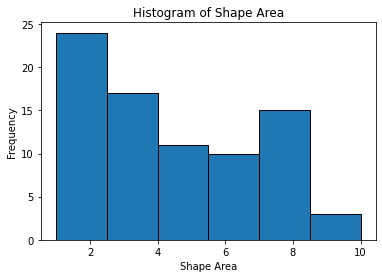

In [59]:
plt.hist(coeur_fires_filter['Shape_Area'], bins=6, range=(1, 10), edgecolor='black')
plt.title('Histogram of Shape Area')
plt.xlabel('Shape Area')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

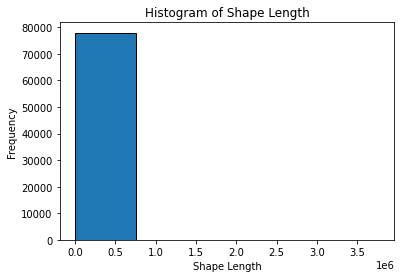

In [62]:
plt.hist(coeur_fires_filter['Shape_Length'], bins=5, edgecolor='black')  # Specify the number of bins
plt.title('Histogram of Shape Length')
plt.xlabel('Shape Length')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

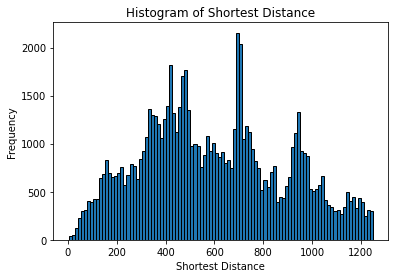

In [65]:
plt.hist(coeur_fires_filter['Shortest_distance'], bins=100, edgecolor='black') 
plt.title('Histogram of Shortest Distance')
plt.xlabel('Shortest Distance')
plt.ylabel('Frequency')
plt.show()

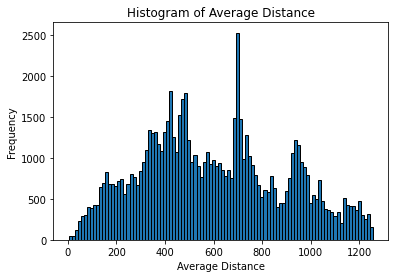

In [67]:
plt.hist(coeur_fires_filter['Average_distance'], bins=100, edgecolor='black') 
plt.title('Histogram of Average Distance')
plt.xlabel('Average Distance')
plt.ylabel('Frequency')
plt.show()

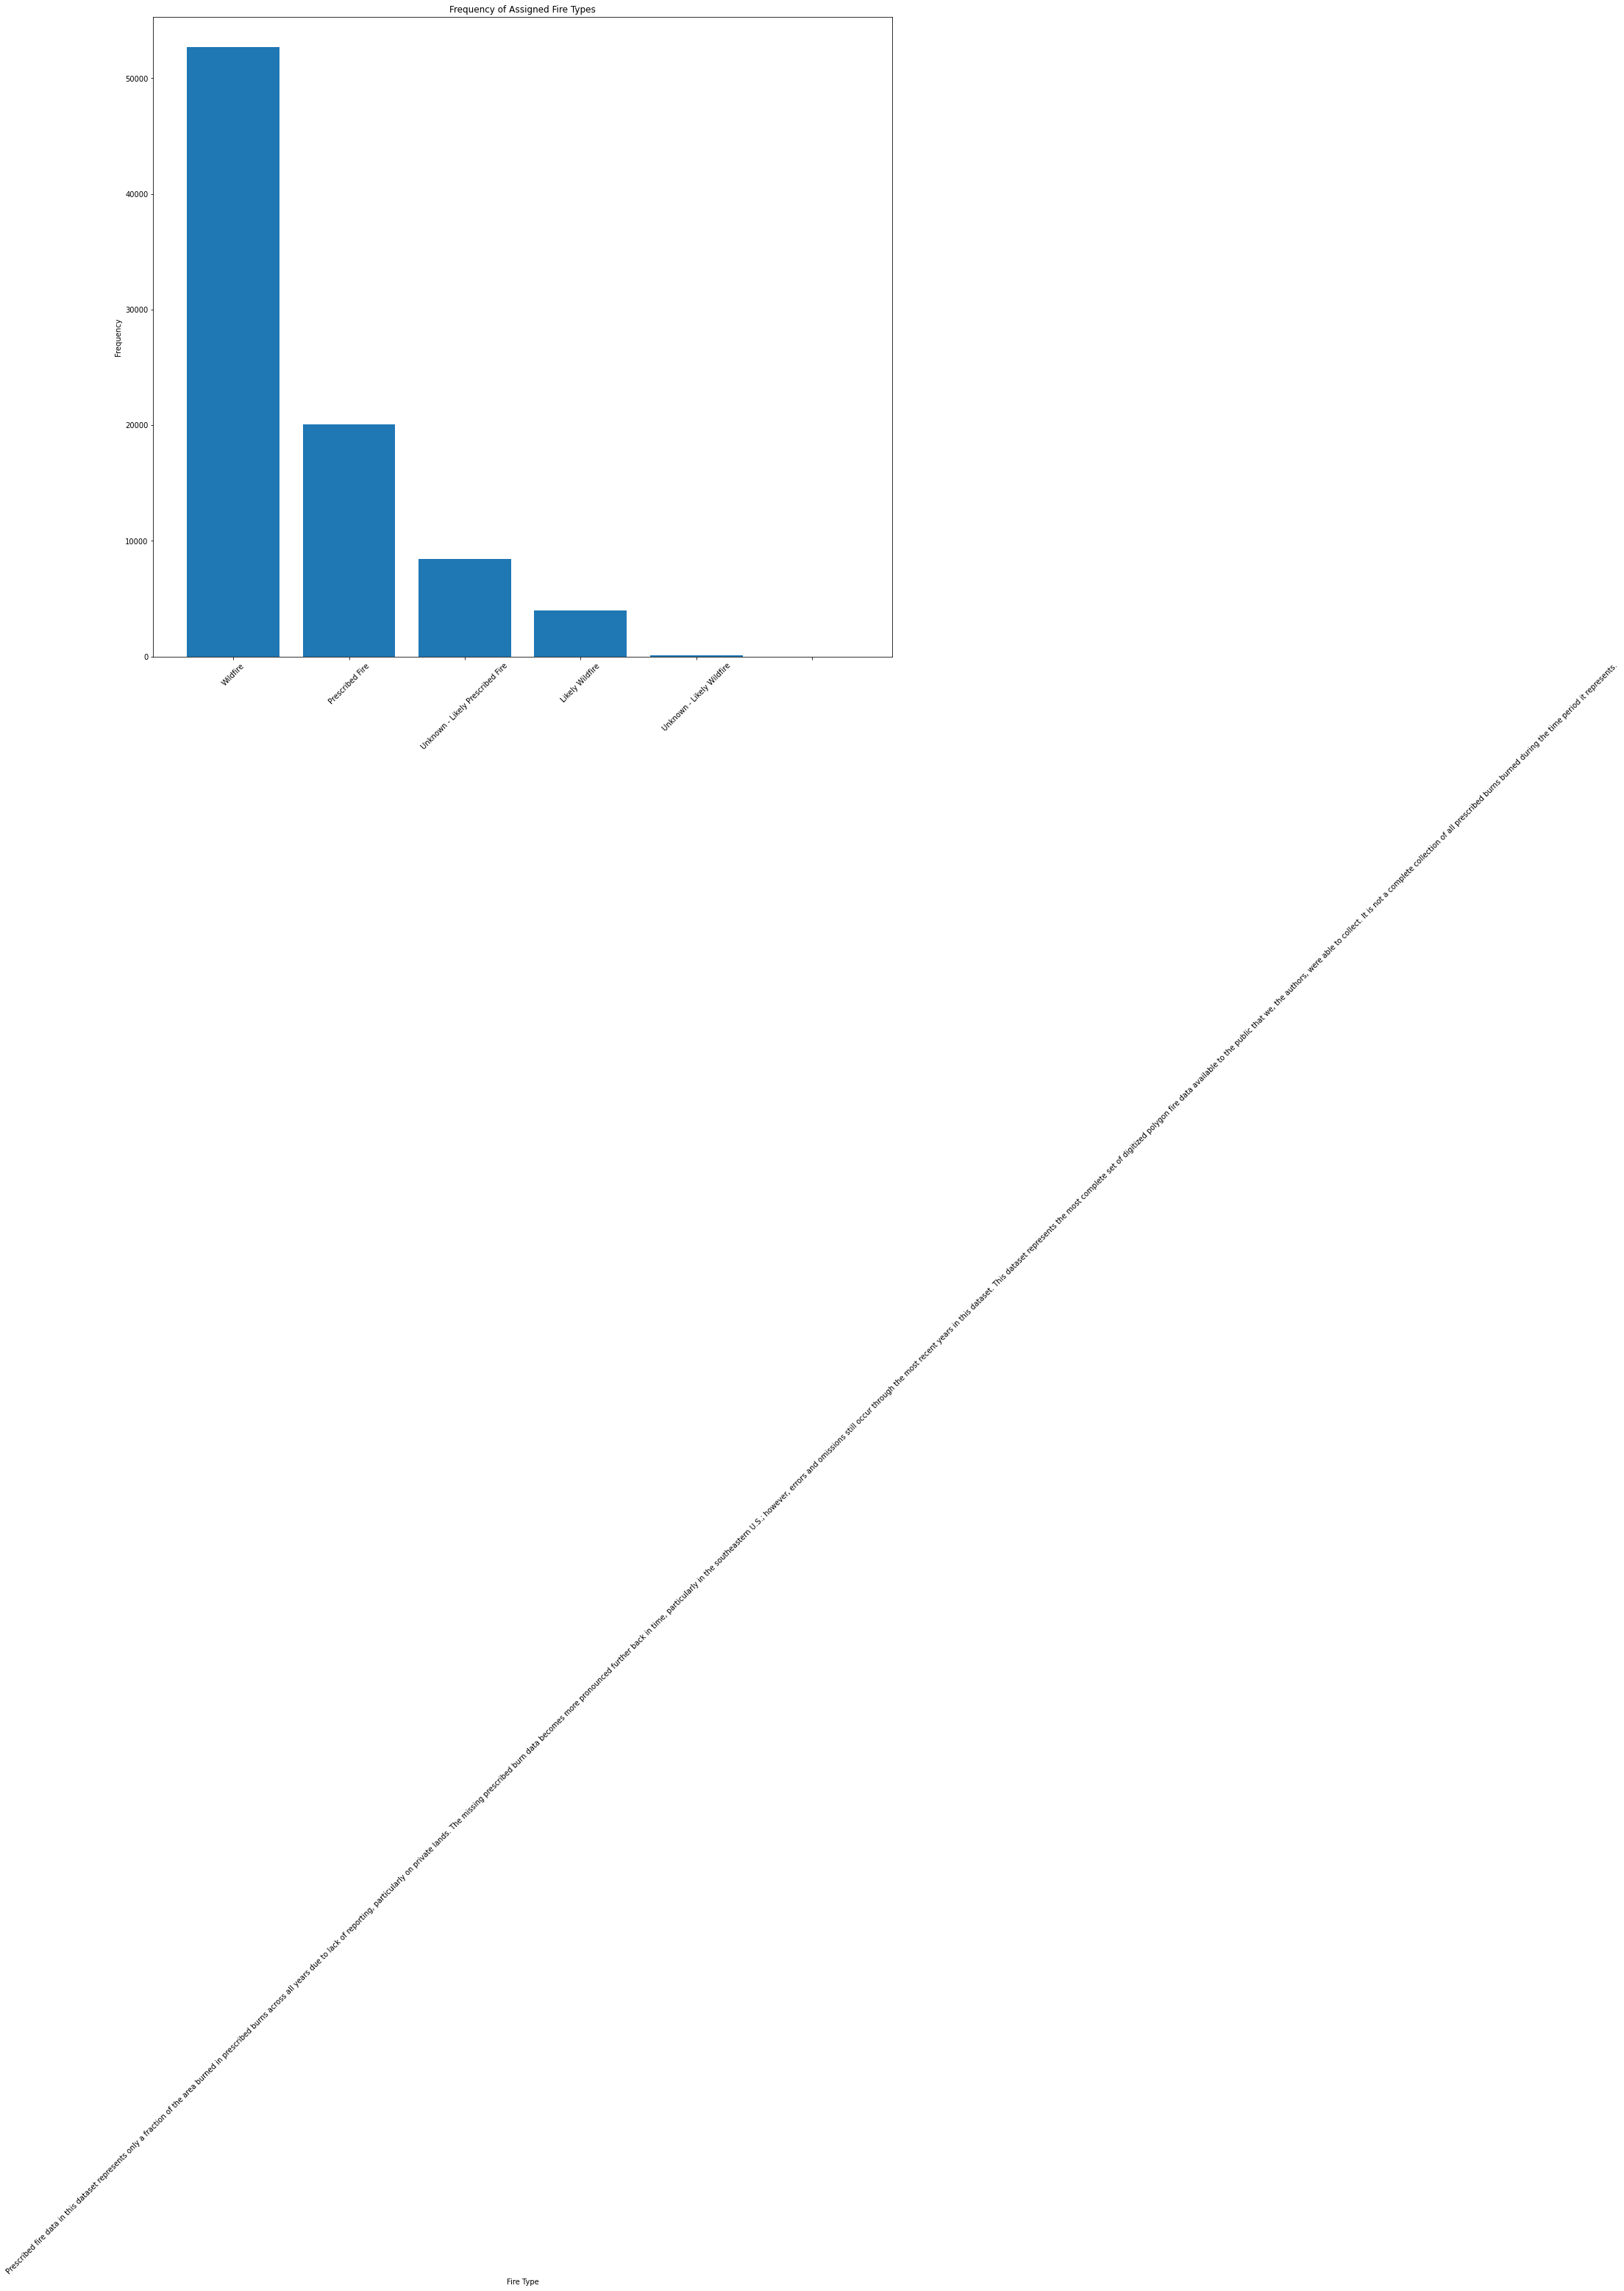

In [73]:
plt.figure(figsize=(18, 16))
fire_type_counts = coeur_fires_filter['Assigned_Fire_Type'].value_counts()
plt.bar(fire_type_counts.index, fire_type_counts)
plt.title('Frequency of Assigned Fire Types')
plt.xlabel('Fire Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## smoke estimaes chosen and why: shape area and distance
based of the visual shape area, and distance had the best spread  and peaks of interest whereas firetype had a huge disparity between likelyhood each type was not clear and length did not have enough varibility in my city

# smoke estimate formula chosen: (Area/Distance) ^2 but which distance (average or shortest) 
-  Why: I chose average and not shortest
##### because the average distance smooths out variations, providing an estimate of the fire's broader impact, while the shortest distance emphasizes immediate or localized effects, making it suitable for high-risk, nearby areas. 

In [141]:
# fill nulls with 0 
#coeur_fires_filter[['Shape_Area', 'Average_distance','Shortest_distance']] = coeur_fires_filter[['Shape_Area', 'Average_distance','Shortest_distance']].fillna(0)
                                         
# Calculate and add (shape_area / average distance)^2 as a new column
coeur_fires_filter['Area_Average_Distance_Squared'] = ((coeur_fires_filter['Shape_Area']) / (coeur_fires_filter['Average_distance'])) ** 2
coeur_fires_filter['Area_Shortest_Distance_Squared'] = ((coeur_fires_filter['Shape_Area']) / (coeur_fires_filter['Shortest_distance'])) ** 2

In [142]:
coeur_subset = ['Fire_Year', 'GIS_Acres', 'Shortest_distance','Shape_Area', 'Shortest_distance','Average_distance', 'Area_Average_Distance_Squared','Area_Shortest_Distance_Squared']
coeur_df = coeur_fires_filter[coeur_subset]

In [143]:
coeur_df_1 = coeur_df.groupby('Fire_Year').mean().reset_index()
coeur_df_1 

,Fire_Year,GIS_Acres,Shortest_distance,Shape_Area,Shortest_distance,Average_distance,Area_Average_Distance_Squared,Area_Shortest_Distance_Squared
0,1963,693.949136,609.691014,2.808313e+06,609.691014,610.013847,4.027126e+09,4.190306e+09
1,1964,1228.901417,623.936665,4.973188e+06,623.936665,624.466761,8.882221e+08,9.020184e+08
2,1965,753.312532,588.930012,3.048548e+06,588.930012,589.241427,4.971877e+10,4.973628e+10
3,1966,1703.514155,610.720318,6.893877e+06,610.720318,611.254100,5.058083e+09,5.246063e+09
4,1967,1138.451539,638.121377,4.607150e+06,638.121377,638.515811,4.465429e+10,4.546024e+10
5,1968,831.313474,637.770158,3.364206e+06,637.770158,638.202535,2.289966e+09,2.424899e+09
6,1969,638.751724,646.730026,2.584937e+06,646.730026,647.128947,4.855948e+08,4.917961e+08
7,1970,1809.993841,612.488701,7.324785e+06,612.488701,612.937661,9.100050e+09,9.333374e+09
8,1971,1598.764214,650.979360,6.469969e+06,650.979360,651.516376,7.927055e+09,8.230781e+09
9,1972,838.668223,616.324927,3.393970e+06,616.324927,616.752257,7.573907e+08,7.777510e+08


#### As you can see from the data shortest distance has a higher reboustness than average which will not be our smoke estimate

In [145]:
coeur_subset_result = ['Fire_Year', 'GIS_Acres', 'Shortest_distance', 'Area_Average_Distance_Squared']
coeur_df_result = coeur_df_1[coeur_subset_result]

In [147]:
coeur_df_result.rename(columns = {'Area_Average_Distance_Squared':'Smoke_estimate'}, inplace = True)
coeur_df_result


/var/folders/zl/sc371gd517n0657kksp61jth0000gn/T/ipykernel_2301/3427039471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coeur_df_result.rename(columns = {'Area_Average_Distance_Squared':'Smoke_estimate'}, inplace = True)


,Fire_Year,GIS_Acres,Shortest_distance,Shortest_distance,Smoke_estimate
0,1963,693.949136,609.691014,609.691014,4.027126e+09
1,1964,1228.901417,623.936665,623.936665,8.882221e+08
2,1965,753.312532,588.930012,588.930012,4.971877e+10
3,1966,1703.514155,610.720318,610.720318,5.058083e+09
4,1967,1138.451539,638.121377,638.121377,4.465429e+10
5,1968,831.313474,637.770158,637.770158,2.289966e+09
6,1969,638.751724,646.730026,646.730026,4.855948e+08
7,1970,1809.993841,612.488701,612.488701,9.100050e+09
8,1971,1598.764214,650.979360,650.979360,7.927055e+09
9,1972,838.668223,616.324927,616.324927,7.573907e+08


In [148]:
coeur_df_result.to_csv('coeur_smoke_estimate_df.csv')

# The next ipynb file will include the AQU comparisions and step two 